In [1]:
from encoders import *
from decoders import *

In [1]:
# enter your image shape
IMAGE_SHAPE = (3, 32, 32)


In [3]:
encoder = ResNet18Encoder()
output = encoder(torch.randn(10, *IMAGE_SHAPE))
print(f"Encoder output shape: {output.shape}")
print(f"Encoder output range: {output.min()}, {output.max()}")

Encoder output shape: torch.Size([10, 512, 1, 1])
Encoder output range: 0.0, 4.525657653808594


In [4]:
LATENT_SHAPE = (128, 1, 1)
decoder = OmniglotDecoder()
output = decoder(torch.randn(10, *LATENT_SHAPE))
print(f"Encoder output shape: {output.shape}")

Encoder output shape: torch.Size([10, 1, 28, 28])


In [62]:
# create a tensor of shape (10, 512) range from -26 to 26
x = torch.randn(10, 512) * 20
print(f"x has range: {x.min()} to {x.max()}")

x has range: -64.39373779296875 to 70.6744384765625


In [70]:
import math
ll = nn.Linear(512, 512)
# Calculate the initialization range
init_range = 1e-3

# Initialize weights uniformly in [-init_range, init_range]
nn.init.uniform_(ll.weight, -init_range, init_range)

# Initialize biases uniformly in [-1/sqrt(fan_in), 1/sqrt(fan_in)]
if ll.bias is not None:
    nn.init.uniform_(ll.bias, -1e-3, 1e-3)

y = ll(x)

print(f"y has range: {y.min()} to {y.max()}")
print(f"exp(0.5 * y) has range: {torch.exp(0.5 * y).min()} to {torch.exp(0.5 * y).max()}")

y has range: -1.0449903011322021 to 0.8784927129745483
exp(0.5 * y) has range: 0.5930389761924744 to 1.5515375137329102


In [1]:
import torch

In [5]:
torch.nn.Parameter(torch.full((1,), 0)[0], requires_grad=False)

Parameter containing:
tensor(0)

In [10]:
torch.nn.Parameter(torch.zeros(1)[0])

Parameter containing:
tensor(0., requires_grad=True)

In [2]:
import utils

In [7]:
for i in range(20):
    print(utils.get_loss_weights(i, recon_intv=0, dkl_intv=10, start_first='dkl'))

(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)


In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [69]:
# Define Gaussian PDF
def gaussian_pdf(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(- (x - mu)**2 / (2 * var))

# calculate the KL divergence
def kl_divergence(mu1, var1, mu2, var2):
    return np.log(var2 / var1) + (var1 + (mu1 - mu2)**2) / (2 * var2) - 0.5


Split ratio: 0.9734050962890877


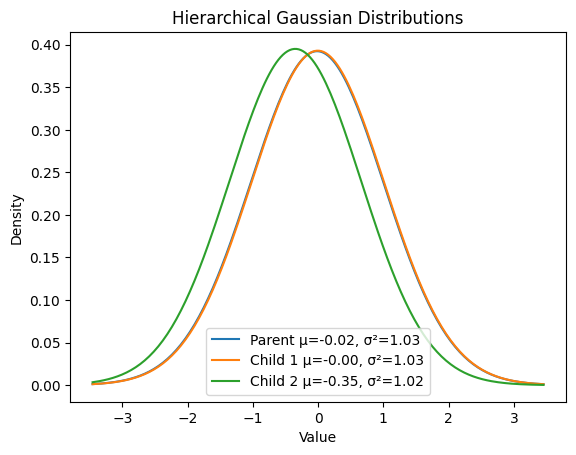

DKL between child 1 and child 2: 0.001621188233023707
DKL between child 2 and child 1: 0.06083589616865903


In [73]:
data = np.random.randn(1000)

# Compute parent mean and variance
mu_parent = np.mean(data)
var_parent = np.var(data)

# Random split weight and clustering
p = np.random.rand()  # random split ratio
print(f"Split ratio: {p}")
mask = np.random.rand(len(data)) < p
# print(f"Mask: {mask}")  
cluster1 = data[mask]
cluster2 = data[~mask]

# Compute children's mean and variance
mu1, var1 = np.mean(cluster1), np.var(cluster1)
mu2, var2 = np.mean(cluster2), np.var(cluster2)

# Gaussian PDF definition
def gaussian_pdf(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(- (x - mu)**2 / (2 * var))

# Generate x-values for plotting
x = np.linspace(min(data), max(data), 200)
pdf_parent = gaussian_pdf(x, mu_parent, var_parent)
pdf1 = gaussian_pdf(x, mu1, var1)
pdf2 = gaussian_pdf(x, mu2, var2)

# Plot parent and child Gaussian PDFs
plt.figure()
plt.plot(x, pdf_parent, label=f'Parent μ={mu_parent:.2f}, σ²={var_parent:.2f}')
plt.plot(x, pdf1,      label=f'Child 1 μ={mu1:.2f}, σ²={var1:.2f}')
plt.plot(x, pdf2,      label=f'Child 2 μ={mu2:.2f}, σ²={var2:.2f}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Hierarchical Gaussian Distributions')
plt.legend()
plt.show()

# print dkl between two children
dkl1 = kl_divergence(mu1, var1, mu_parent, var_parent)
dkl2 = kl_divergence(mu2, var2, mu_parent, var_parent)
print(f"DKL between child 1 and child 2: {dkl1}")
print(f"DKL between child 2 and child 1: {dkl2}")

# print 

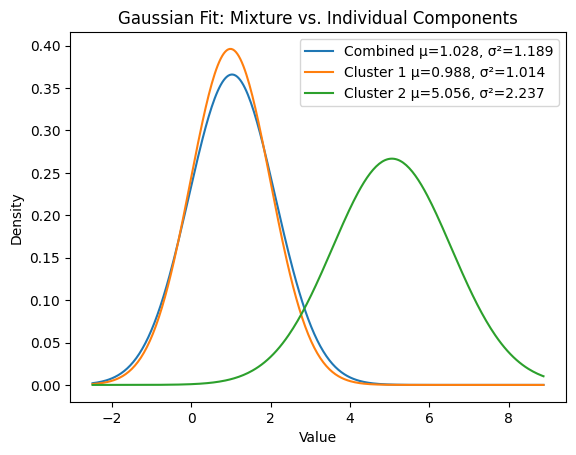

In [87]:
# Generate two synthetic 1-D distributions
n1, n2 = 10000, 100
mu1_true, var1_true = 1, 1
mu2_true, var2_true = 5, 2
data1 = np.random.normal(mu1_true, np.sqrt(var1_true), n1)
data2 = np.random.normal(mu2_true, np.sqrt(var2_true), n2)
data = np.concatenate([data1, data2])

# Compute empirical means and variances
mu_all, var_all = np.mean(data), np.var(data)
mu1_emp, var1_emp = np.mean(data1), np.var(data1)
mu2_emp, var2_emp = np.mean(data2), np.var(data2)

# Gaussian PDF function
def gaussian_pdf(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(- (x - mu)**2 / (2 * var))

# Prepare x-axis
x = np.linspace(min(data), max(data), 300)
pdf_all = gaussian_pdf(x, mu_all, var_all)
pdf1 = gaussian_pdf(x, mu1_emp, var1_emp)
pdf2 = gaussian_pdf(x, mu2_emp, var2_emp)

# Plot all three Gaussian PDFs
plt.figure()
plt.plot(x, pdf_all, label=f'Combined μ={mu_all:.3f}, σ²={var_all:.3f}')
plt.plot(x, pdf1,      label=f'Cluster 1 μ={mu1_emp:.3f}, σ²={var1_emp:.3f}')
plt.plot(x, pdf2,      label=f'Cluster 2 μ={mu2_emp:.3f}, σ²={var2_emp:.3f}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Gaussian Fit: Mixture vs. Individual Components')
plt.legend()
plt.show()

In [88]:
# dkl between two children
dkl1 = kl_divergence(mu1_emp, var1_emp, mu2_emp, var2_emp)
# dkl between two children
dkl2 = kl_divergence(mu2_emp, var2_emp, mu1_emp, var1_emp)
print(f"KL divergence between child 1 and child 2: {dkl1}")
print(f"KL divergence between child 2 and child 1: {dkl2}")
print(f"Sum of KL divergences: {dkl1 + dkl2}")

KL divergence between child 1 and child 2: 4.216525629148143
KL divergence between child 2 and child 1: 7.97032760951835
Sum of KL divergences: 12.186853238666494


In [61]:
0.5 * var2_emp + 0.5 * var1_emp + 0.5 * (mu1_emp - mu_all)**2 + 0.5 * (mu2_emp - mu_all)**2

np.float64(5.573813516696156)

In [59]:
var_all

np.float64(5.573813516696158)